Complete notebook available at: https://github.com/ai4up/ufo-prediction/blob/main/demo/demo.ipynb

## Motivation

Building attributes such as building height, type, and construction year are not available for all buildings in EUBUCCO. However, for many prospective use cases of the dataset, such as energy modeling, the building attributes are of high importance. This notebook shows how the available building footprints can be used to estimate missing building attributes with supervised machine learning.

In [2]:
# -.-|m { input: false }

# standard libs
import os
import sys
import logging
import gc

# project lib
PROJECT_SRC_PATH = os.path.join( '/workspace/workspace/ufo-prediction', 'src')
sys.path.append(PROJECT_SRC_PATH)

import visualizations
from prediction_age import AgePredictor, AgeClassifier, AgePredictorComparison
import preprocessing as pp
import dataset

# external libs
import numpy as np
import pandas as pd
import geopandas as gpd
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-mskf691r because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# -.-|m { input: false }

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

## Data

Demo sample of ~20k buildings for Spain, ~50k for France, and 170k for the Netherlands. All 117 urban form features, lat lon, as well as some auxiliary attributes like city name, neighborhood, building type, etc. are included.

The demo samples are stored using Git Large File Storage (LFS). To download them explicitly use:

In [3]:
# # When loading ufo data
# #DATA_DIR = '.'
# current_directory = os.getcwd()
# print(current_directory)

# path_data_NLD = os.path.join('/workspace/workspace/ufo-prediction', 'demo', 'df-NLD.pkl')
# path_data_FRA = os.path.join('/workspace/workspace/ufo-prediction', 'demo', 'df-FRA.pkl')
# path_data_ESP = os.path.join('/workspace/workspace/ufo-prediction', 'demo', 'df-ESP.pkl')
# print(path_data_NLD)
# df = pd.read_pickle(path_data_NLD)


/workspace
/workspace/workspace/ufo-prediction/demo/df-NLD.pkl


In [4]:
path_data_NLD = os.path.join(dataset.DATA_DIR, 'ufo-CNN_ALL.csv')
df = pd.read_csv(path_data_NLD, encoding='latin1')

In [5]:
df['age']

0       1960.0
1       1965.0
2       1928.0
3       1931.0
4       1995.0
         ...  
2108    1976.0
2109    1963.0
2110    1974.0
2111    2002.0
2112    2003.0
Name: age, Length: 2113, dtype: float64

In [6]:
df.drop(columns=['CNN_age_bracket'])

,id,source_file,dist_to_closest_int,av_footprint_area_within_buffer_100,street_betweeness_global_max_within_buffer_500,av_elongation_within_buffer_500,geometry,std_building_footprint_city,block,blocks_2_to_4,...,buildings_within_buffer_100,street_betweeness_global_max_within_buffer_100,TouchesIndexes,street_based_block_av_phi_inter_buffer_500,total_length_street_city,total_buildings_footprint_city,Phi,street_based_block_std_area_inter_buffer_100,type,neighborhood
0,v0.1-NLD.1.10_1-22487,NL_lod12_2d_pand_2,80.417349,312.445480,0.135796,0.655093,POINT (4082503.036765486 3342366.9156441647),343.163256,b6ee09d8,2801.0,...,40.0,0.017439,[22487],0.429858,942530.341312,2.917612e+06,0.579591,2.249724e+06,NaN,53d62edb
1,v0.1-NLD.1.10_1-2274,NL_lod12_2d_pand_2,34.591707,232.236078,0.307461,0.674780,POINT (4084008.847832444 3334528.978847456),343.163256,8ae7baf0,2801.0,...,53.0,0.087692,"[2274, 20436, 9479, 2923]",0.432832,942530.341312,2.917612e+06,0.303103,2.066548e+06,NaN,f73dc321
2,v0.1-NLD.1.11_1-12774,NL_lod12_2d_pand_2,19.308712,109.864304,0.056066,0.703447,POINT (4089711.3856652677 3337663.673187498),424.396815,1c7710d4,3121.0,...,27.0,0.051693,[12774],0.329155,888712.235310,2.887787e+06,0.429084,5.559368e+05,NaN,bde9e9aa
3,v0.1-NLD.1.11_1-18467,NL_lod12_2d_pand_2,11.666631,106.177111,0.157550,0.644019,POINT (4099114.982764387 3336947.588670559),424.396815,3537afeb,3121.0,...,111.0,0.093344,"[5031, 18467]",0.411736,888712.235310,2.887787e+06,0.558643,1.617388e+06,NaN,d2b16a1a
4,v0.1-NLD.1.11_1-4079,NL_lod12_2d_pand_2,29.881210,126.434745,0.110367,0.654707,POINT (4099251.581367658 3337197.4897597586),424.396815,1b072026,3121.0,...,52.0,0.103494,[4079],0.436095,888712.235310,2.887787e+06,0.622589,2.046391e+06,NaN,d2b16a1a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2108,v0.1-FRA.9.3.2.14_1-2431,BATIMENT-normandie,17.130284,85.060422,0.118125,0.632948,POINT (3488299.448703552 3002949.818799261),240.029254,3d2cb82a,1582.0,...,8.0,0.099810,[2431],0.225418,608321.057638,1.671174e+06,0.581062,3.541002e+06,residential,479dc141
2109,v0.1-FRA.9.3.4.2_1-5657,BATIMENT-normandie,125.131950,63.898899,0.071257,0.603756,POINT (3507369.0635800045 2972866.2183200964),463.258047,2dcbbf61,1518.0,...,29.0,0.025715,"[5656, 5657]",0.436597,559702.734166,1.836864e+06,0.344796,4.669612e+05,residential,4297c65c
2110,v0.1-FRA.9.3.4.5_1-3976,BATIMENT-normandie,146.401342,131.322217,0.101619,0.608976,POINT (3519874.7466274397 2950097.519979058),223.777076,765a5927,1482.0,...,25.0,0.072957,[3976],0.394060,647603.388207,1.297290e+06,0.572295,8.878829e+05,residential,08453a55
2111,v0.1-FRA.9.4.2.3_1-2458,BATIMENT-normandie,9.294193,82.455834,0.153913,0.644721,POINT (3586273.8271734808 2898541.292937424),574.200790,6242ac7d,987.0,...,87.0,0.071388,"[2458, 6623]",0.351135,209509.759359,1.108007e+06,0.550500,1.189182e+06,residential,03d890dc


In [7]:
df = df.rename(columns={'age': 'age_right'})


In [8]:
print(len(df))

2113


## Prediction

In [9]:
xgb_model_params = {'tree_method': 'hist', 
                    # 'n_estimators': 500
                    }
xgb_hyperparams = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 500,
    'colsample_bytree': 0.5,
    'subsample': 1.0,
}

### Regression

2024-03-26 13:05:48,424 | INFO : Dataset length: 2113
2024-03-26 13:05:48,430 | INFO : Dataset allocated memory: 2 MB
2024-03-26 13:05:48,433 | INFO : No abort signal received. Continuing... To abort please create workspace/ufo-prediction/metadata/local-9c9c5c4e.abort.
2024-03-26 13:05:48,434 | INFO : Dataset standard deviation: 32.10736844052994
2024-03-26 13:05:48,435 | INFO : Dataset mean age: 1962.061050638902
2024-03-26 13:05:48,436 | INFO : Training dataset length: 1690
2024-03-26 13:05:48,436 | INFO : Test dataset length: 423
2024-03-26 13:05:48,449 | INFO : Test dataset standard deviation after preprocessing: 30.125509555766882
2024-03-26 13:05:48,450 | INFO : Test dataset mean age after preprocessing: 1964.2678132678134
2024-03-26 13:05:48,450 | INFO : Training dataset length after preprocessing: 1621
2024-03-26 13:05:48,451 | INFO : Test dataset length after preprocessing: 407
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, us

MAE: 20.23 y
RMSE: 25.31 y
R2: 0.2922
Energy need for heating in kWh/(m²a) R2: nan
Energy need for heating in kWh/(m²a) MAPE: nan


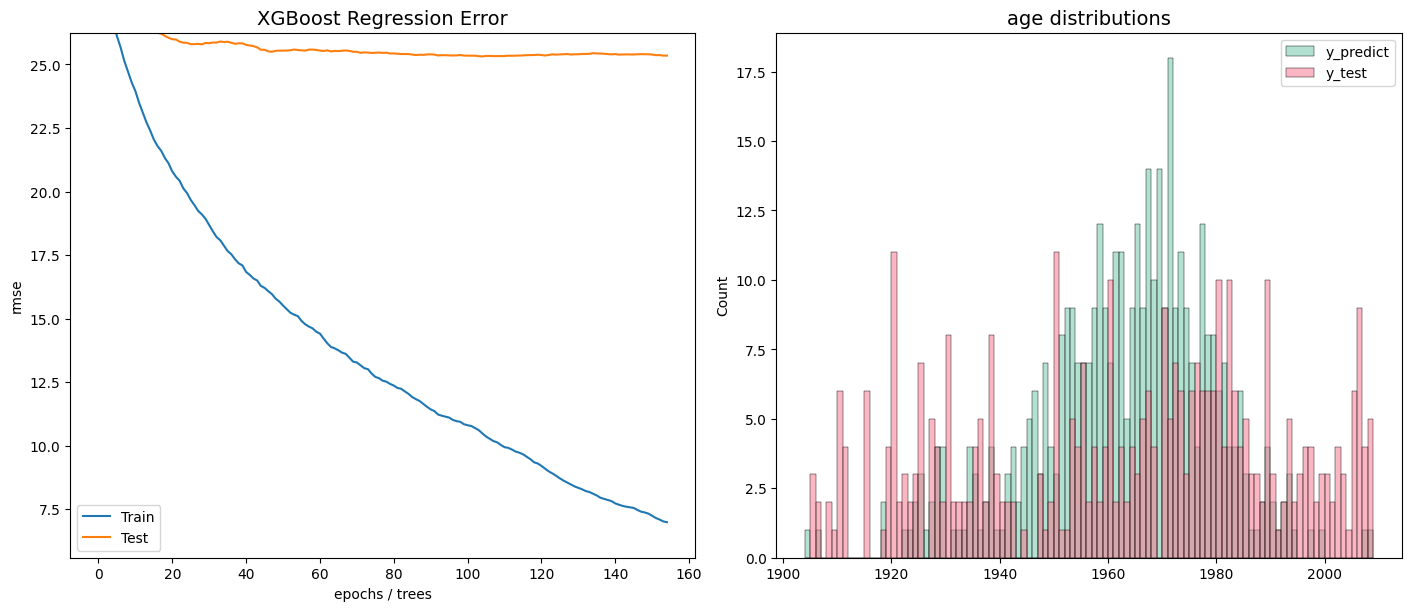

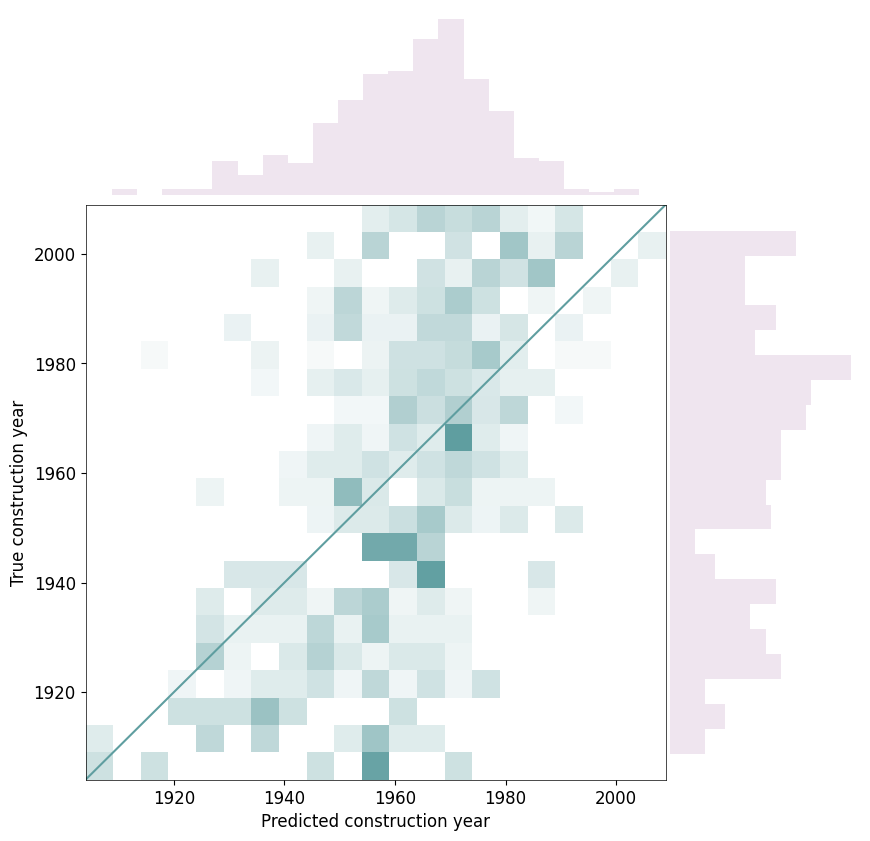

In [10]:
predictor = AgePredictor(
    model=XGBRegressor(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    early_stopping=True,
    hyperparameters=xgb_hyperparams,
    # preprocessing_stages=[pp.remove_outliers, pp.categorical_to_int_byList, pp.convert_to_double_byList]
    preprocessing_stages=[pp.remove_outliers]
)

predictor.evaluate()


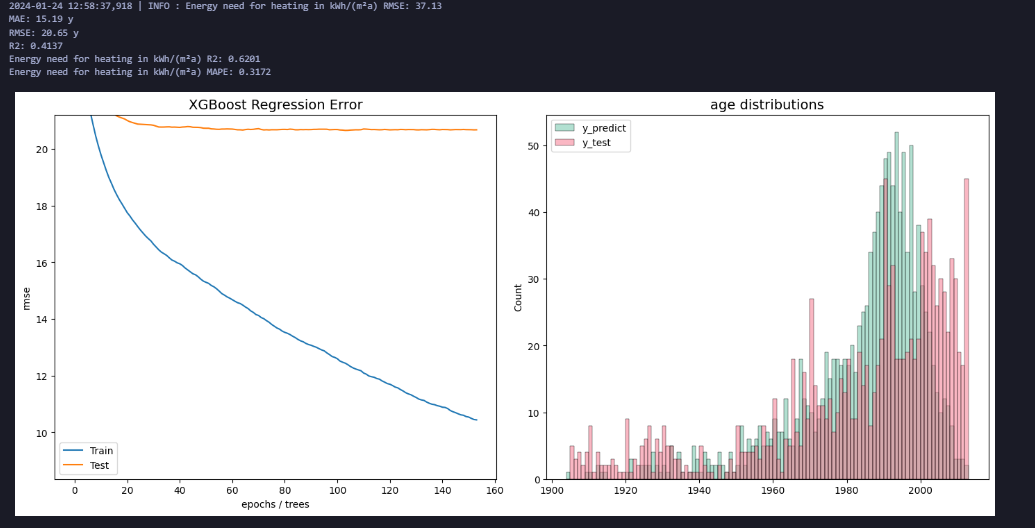
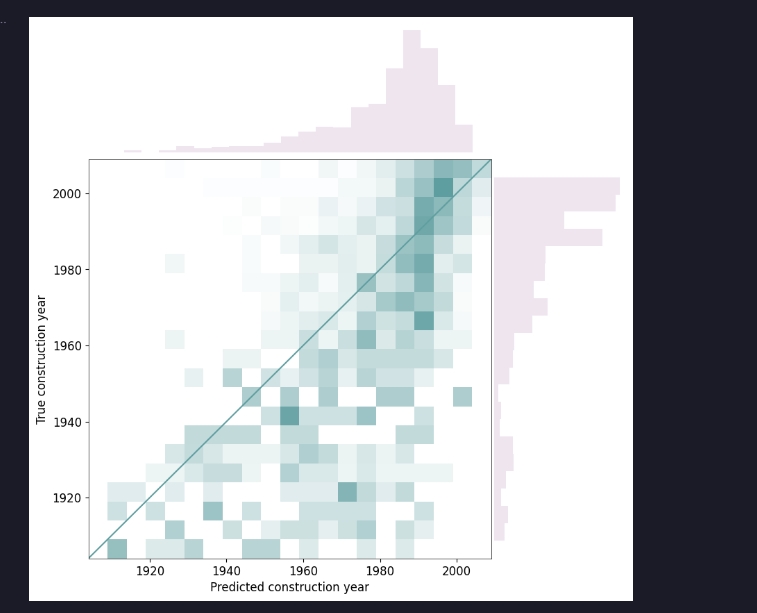

### Classification

2024-03-26 12:44:54,064 | INFO : Generated bins: [1900, 1965, 1975, 1992, 2006, 2015, 2022]
2024-03-26 12:44:54,065 | INFO : Generated bins with the following labels: ['1900-1964', '1965-1974', '1975-1991', '1992-2005', '2006-2014', '2015-2021']
2024-03-26 12:44:54,071 | INFO : Dataset length: 2113
2024-03-26 12:44:54,078 | INFO : Dataset allocated memory: 2 MB
2024-03-26 12:44:54,082 | INFO : No abort signal received. Continuing... To abort please create workspace/ufo-prediction/metadata/local-1f413021.abort.
2024-03-26 12:44:54,083 | INFO : Training dataset length: 1690
2024-03-26 12:44:54,084 | INFO : Test dataset length: 423
2024-03-26 12:44:54,085 | INFO : Test cities: ['Almelo' 'Chozas de Abajo' "'s-Gravenhage" 'Terneuzen'
 'Cervera del Maestre' 'Enschede' 'Barcelona' 'Stadskanaal' 'Audenge'
 'Venlo' 'Vic-en-Bigorre' 'Helmond' "'s-Hertogenbosch" 'La Roche-sur-Yon'
 'Saint-Tropez' 'Oldenzaal' 'Millau' 'Eindhoven' 'Amstelveen' 'Utrecht'
 'Rotterdam' 'Diemen' 'Sluis' 'Borsele' 'Vill

Classification report:
               precision    recall  f1-score  support
1900-1964      0.691542  0.751351  0.720207      185
1965-1974      0.407407  0.458333  0.431373       48
1975-1991      0.471429  0.358696  0.407407       92
1992-2005      0.260000  0.295455  0.276596       44
2006-2014      0.206897  0.214286  0.210526       28
2015-2021      0.333333  0.100000  0.153846       10
accuracy       0.525799  0.525799  0.525799        0
macro avg      0.395101  0.363020  0.366659      407
weighted avg   0.519481  0.525799  0.518499      407
Cohen’s kappa: 0.3251
Matthews correlation coefficient (MCC): 0.3264


FixedFormatter should only be used together with FixedLocator


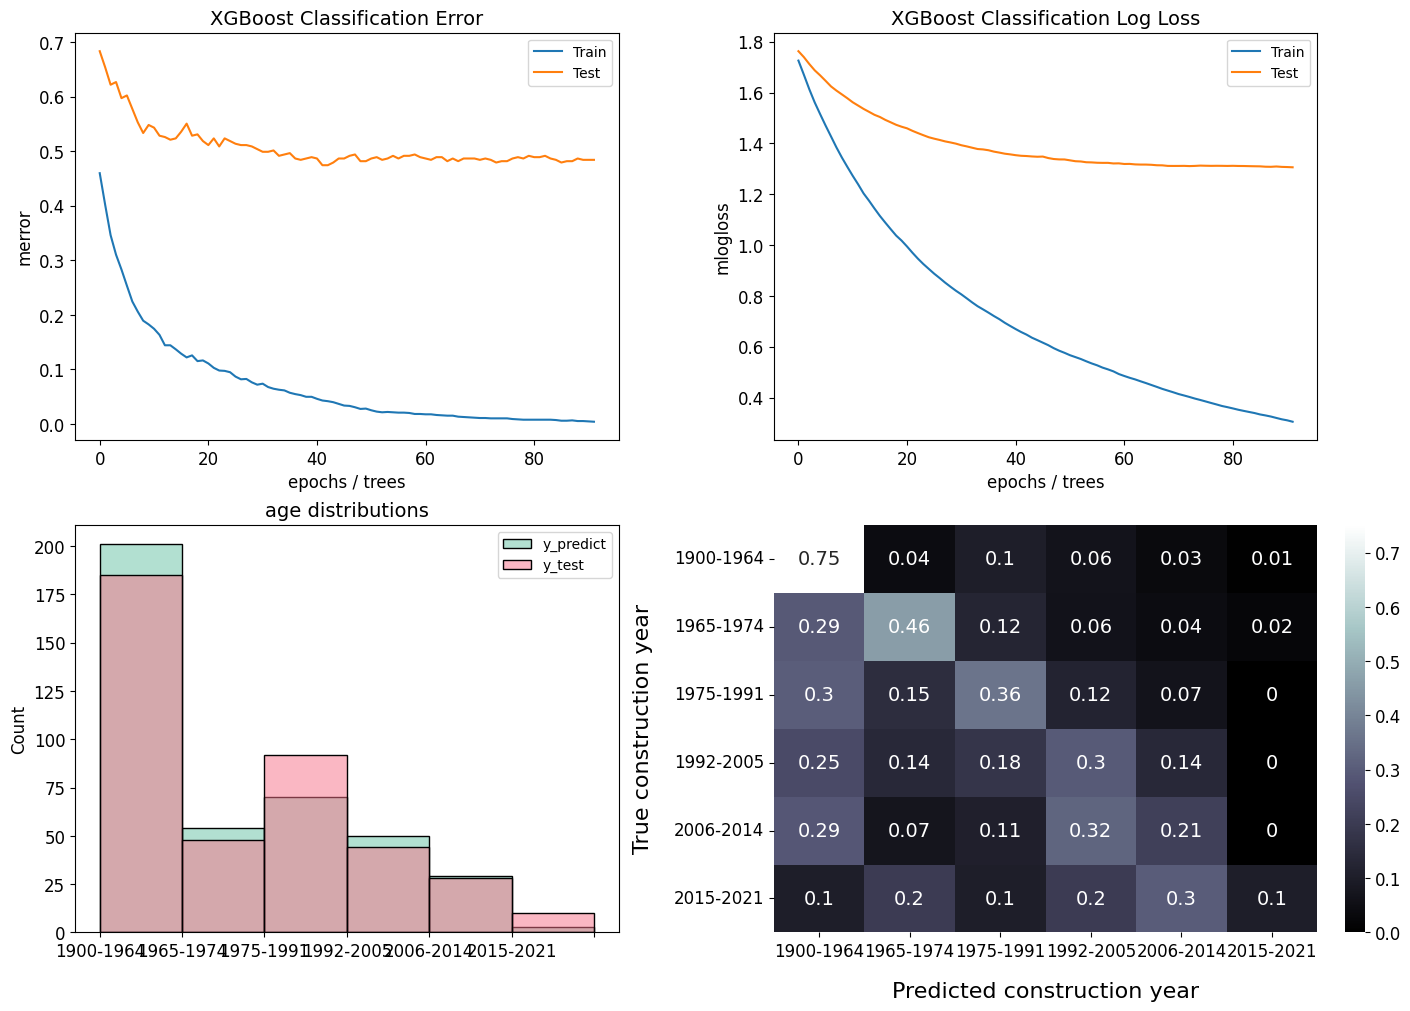

In [9]:
tabula_nl_bins = [1900, 1965, 1975, 1992, 2006, 2015, 2022]
equally_sized_bins = (1900, 2020, 10)

classifier = AgeClassifier(
    model=XGBClassifier(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    mitigate_class_imbalance=True,
    # bin_config=equally_sized_bins,
    bins=tabula_nl_bins,
)
classifier.evaluate()

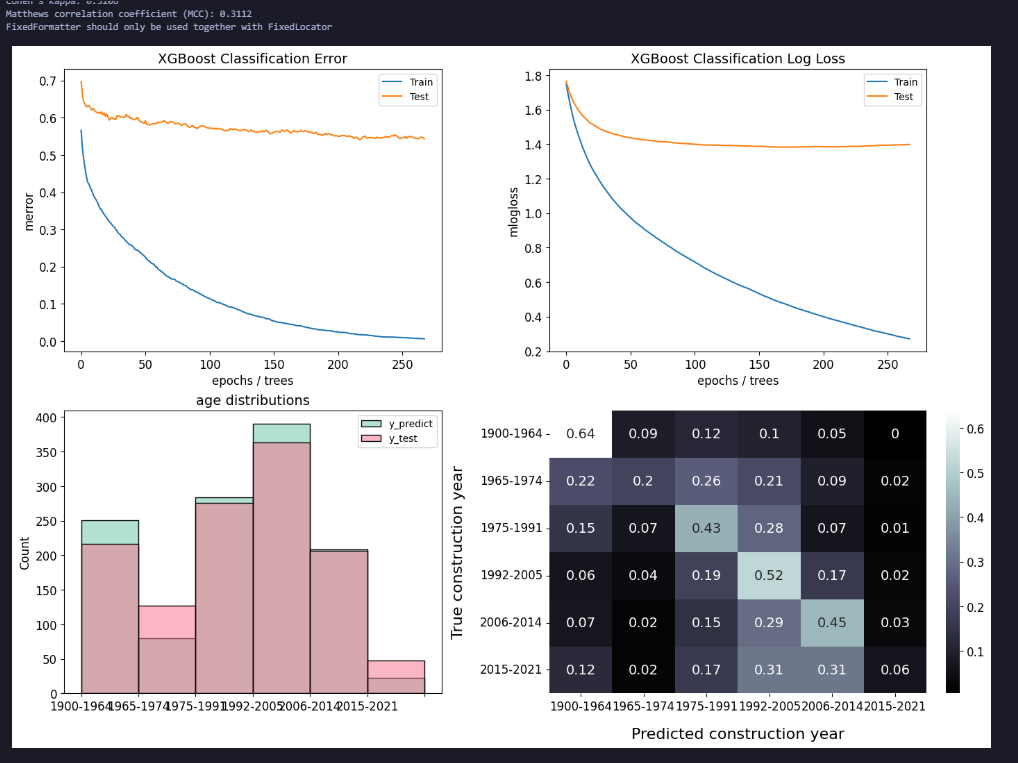

### Country and generalization comparison

The `AgePredictorComparison` faciliates comparisons between differently configured training runs, for example to compare the prediction performance between countries, cross-validation strategies, oversampling strategies or any other preprocessing steps.

In [21]:
comparison_config = {
    'Spain': {'df': path_data_ESP},
    'France': {'df': path_data_FRA},
    'Netherlands': {'df': path_data_NLD},
}

grid_comparison_config = {
    'random-cv': {'cross_validation_split': pp.cross_validation},
    'neighborhood-cv': {'cross_validation_split': pp.neighborhood_cross_validation},
    'city-cv': {'cross_validation_split': pp.city_cross_validation},
}

comparison = AgePredictorComparison(
    exp_name='demo',
    model=XGBRegressor(**xgb_model_params),
    df=None,
    frac=0.5,
    cross_validation_split=None,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    compare_feature_importance=False,
    compare_classification_error=False,
    include_baseline=False,
    save_results=False,
    garbage_collect_after_training=True,
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
)

results = comparison.evaluate()

2024-01-17 14:50:47,195 | INFO : Starting experiment Spain_random-cv...


2024-01-17 14:53:18,314 | INFO : Dataset length: 4226188
2024-01-17 14:53:18,319 | INFO : Dataset allocated memory: 4385 MB
2024-01-17 14:53:20,237 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs/local-33f2404e.abort.
2024-01-17 14:53:20,256 | INFO : Dataset standard deviation: 48.35942318636823
2024-01-17 14:53:20,263 | INFO : Dataset mean age: 1971.7313162594755
2024-01-17 14:53:20,264 | INFO : Training dataset length: 3380950
2024-01-17 14:53:20,264 | INFO : Test dataset length: 845238
2024-01-17 14:53:33,818 | INFO : Test dataset standard deviation after preprocessing: 25.909066171213233
2024-01-17 14:53:33,820 | INFO : Test dataset mean age after preprocessing: 1980.6306878251494
2024-01-17 14:53:33,821 | INFO : Training dataset length after preprocessing: 3058384
2024-01-17 14:53:33,821 | INFO : Test dataset length after preprocessing: 764264
`early_stopping_rounds` in `fit` method is deprecated for better compatibility

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/workspace/ufo-prediction/demo/df-FRA.pkl'

In [ ]:
results

,name,R2,R2_std,MAE,MAE_std,RMSE,RMSE_std,within_5_years,within_10_years,within_20_years,R2_seed_0
8,Netherlands_city-cv,0.135401,0.0,18.030643,0.0,23.598668,0.0,0.221385,0.392977,0.638903,0.135401
7,France_city-cv,0.187767,0.0,18.645831,0.0,23.772030,0.0,0.176875,0.345911,0.615315,0.187767
6,Spain_city-cv,0.197072,0.0,23.840955,0.0,29.563272,0.0,0.126411,0.247178,0.494357,0.197072
3,Spain_neighborhood-cv,0.198503,0.0,23.779078,0.0,29.536916,0.0,0.129797,0.247178,0.506772,0.198503
5,Netherlands_neighborhood-cv,0.304538,0.0,15.884060,0.0,21.164937,0.0,0.241489,0.444702,0.699700,0.304538
4,France_neighborhood-cv,0.330228,0.0,16.306574,0.0,21.586864,0.0,0.211348,0.408337,0.705209,0.330228
0,Spain_random-cv,0.363164,0.0,20.108252,0.0,26.328608,0.0,0.180587,0.355530,0.592551,0.363164
1,France_random-cv,0.511105,0.0,12.372172,0.0,18.443089,0.0,0.369564,0.593466,0.806340,0.511105
2,Netherlands_random-cv,0.575725,0.0,10.203823,0.0,16.531180,0.0,0.525335,0.695626,0.827052,0.575725


In [ ]:
del comparison, predictor, classifier, results, df, df_temp, df_temp2, df_dropped
gc.collect()